# FP-Growth Algorithm

Market basket analysis es el proceso de identificar y extraer patrones significativos de los conjuntos de transacciones.



## 1. Collect the Data

In [108]:
# Importar librerias
import math
import numpy as np
import pandas as pd
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from matplotlib.ticker import ScalarFormatter
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import association_rules

# Lectura de datos
aisles_df = pd.read_csv('Data/aisles.csv')
departments_df = pd.read_csv('Data/departments.csv')
orders_df = pd.read_csv('Data/orders.csv')
order_products_prior_df = pd.read_csv('Data/order_products__prior.csv')
order_products_train_df = pd.read_csv('Data/order_products__train.csv')
products_df = pd.read_csv('Data/products.csv')

In [109]:
# Agrupa los datos de las tablas en un solo data frame
order_products = pd.DataFrame()
# order_products = pd.concat([order_products_prior_df, order_products_train_df]) El costo computacional de prior impide incluirlo en el proceso
order_products = order_products_train_df
order_products = order_products.merge(products_df, on = 'product_id', how = 'left')
order_products = order_products.merge(aisles_df, on = 'aisle_id', how = 'left')
order_products = order_products.merge(departments_df, on = 'department_id', how = 'left')
order_products = order_products.merge(orders_df, on = 'order_id', how = 'left')
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs,112108,train,4,4,10,9.0
2,1,10246,3,0,Organic Celery Hearts,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
3,1,49683,4,0,Cucumber Kirby,83,4,fresh vegetables,produce,112108,train,4,4,10,9.0
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods,112108,train,4,4,10,9.0


In [110]:
# Products
order_product = order_products[['order_id', 'product_name']]
order_product_arrays = order_product.groupby('order_id')['product_name'].apply(list)
order_product_list = order_product_arrays.tolist()

# Aisle
order_aisle = order_products[['order_id', 'aisle']]
order_aisle_arrays = order_aisle.groupby('order_id')['aisle'].apply(list)
order_aisle_list = order_aisle_arrays.tolist()

# Department
order_department = order_products[['order_id', 'department']]
order_department_arrays = order_department.groupby('order_id')['department'].apply(list)
order_department_list = order_department_arrays.tolist()

In [111]:
encoder = TransactionEncoder()

# Product transactions
product_transactions = encoder.fit(order_product_list).transform(order_product_list)
product_itemsets = pd.DataFrame(product_transactions, columns = encoder.columns_)

# Aisle transactions
aisle_transactions = encoder.fit(order_aisle_list).transform(order_aisle_list)
aisle_itemsets = pd.DataFrame(aisle_transactions, columns = encoder.columns_)

# Department transactions
deparment_transactions = encoder.fit(order_department_list).transform(order_department_list)
department_itemsets = pd.DataFrame(deparment_transactions, columns = encoder.columns_)

## 2. FP-Growth

In [112]:
# Product FP-Growth
fpgrowth_product = fpgrowth(product_itemsets, min_support=0.0015, use_colnames=True)

# Aisle FP-Growth
fpgrowth_aisle = fpgrowth(aisle_itemsets, min_support=0.0015, use_colnames=True)

# Department FP-Growth
fpgrowth_department = fpgrowth(department_itemsets, min_support=0.0015, use_colnames=True)

## 3. Association Rules

In [113]:
# Product Association Rules
product_rules = association_rules(fpgrowth_product, metric = "confidence", min_threshold = 0.25)

# Aisle Association Rules
aisle_rules = association_rules(fpgrowth_aisle, metric = "confidence", min_threshold = 0.50)

## 4. Evaluate Association Rules

### 4.1 Product Association Rules

In [114]:
product_rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
count,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000,274.000000
mean,0.010032,0.103784,0.003063,0.318783,4.438138,0.001973,1.326676,0.673568
std,0.009725,0.036218,0.002812,0.059628,7.252355,0.001673,0.138957,0.125584
min,0.002904,0.004390,0.001501,0.250197,1.820493,0.000704,1.158204,0.453666
25%,0.005310,0.083028,0.001677,0.273961,2.281375,0.001151,1.229337,0.565982
50%,0.006951,0.117980,0.002027,0.302502,3.064641,0.001429,1.295488,0.680039
75%,0.010207,0.142719,0.003121,0.346716,3.921600,0.002035,1.391437,0.752680
max,0.083028,0.142719,0.023428,0.598425,71.084466,0.013633,2.196403,0.991258


In [115]:
product_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Organic Hass Avocado),(Bag of Organic Bananas),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044,0.682381
1,"(Bag of Organic Bananas, Organic Hass Avocado)",(Organic Strawberries),0.018444,0.083028,0.005411,0.293388,3.533615,0.003880,1.297703,0.730477
2,"(Organic Strawberries, Organic Hass Avocado)",(Bag of Organic Bananas),0.011729,0.117980,0.005411,0.461339,3.910321,0.004027,1.637430,0.753100
3,"(Organic Hass Avocado, Organic Baby Spinach)",(Organic Strawberries),0.009542,0.083028,0.002515,0.263578,3.174577,0.001723,1.245173,0.691597
4,"(Organic Hass Avocado, Organic Baby Spinach)",(Bag of Organic Bananas),0.009542,0.117980,0.003788,0.396965,3.364687,0.002662,1.462635,0.709566
...,...,...,...,...,...,...,...,...,...,...
269,(Total 2% Greek Strained Yogurt with Cherry 5....,(Banana),0.004939,0.142719,0.001501,0.304012,2.130148,0.000797,1.231748,0.533182
270,(Organic Cripps Pink Apples),(Bag of Organic Bananas),0.005564,0.117980,0.001829,0.328767,2.786641,0.001173,1.314030,0.644732
271,(Icelandic Style Skyr Blueberry Non-fat Yogurt),(Non Fat Raspberry Yogurt),0.005373,0.004390,0.001677,0.312057,71.084466,0.001653,1.447227,0.991258
272,(Non Fat Raspberry Yogurt),(Icelandic Style Skyr Blueberry Non-fat Yogurt),0.004390,0.005373,0.001677,0.381944,71.084466,0.001653,1.609284,0.990279


In [120]:
rows= ((product_rules['lift'] > 3.92))
product_rules[rows].sort_values('lift', ascending = False).reset_index()

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,272,(Non Fat Raspberry Yogurt),(Icelandic Style Skyr Blueberry Non-fat Yogurt),0.004390,0.005373,0.001677,0.381944,71.084466,0.001653,1.609284,0.990279
1,271,(Icelandic Style Skyr Blueberry Non-fat Yogurt),(Non Fat Raspberry Yogurt),0.005373,0.004390,0.001677,0.312057,71.084466,0.001653,1.447227,0.991258
2,204,(Total 2% Lowfat Greek Strained Yogurt With Bl...,(Total 2% with Strawberry Lowfat Greek Straine...,0.004931,0.007416,0.001783,0.361669,48.771079,0.001747,1.554969,0.984350
3,273,(Total 2% Lowfat Greek Strained Yogurt with Pe...,(Total 2% with Strawberry Lowfat Greek Straine...,0.004908,0.007416,0.001730,0.352484,47.532513,0.001694,1.532912,0.983790
4,227,(Yellow Bell Pepper),(Orange Bell Pepper),0.008887,0.014206,0.003018,0.339623,23.906409,0.002892,1.492773,0.966761
...,...,...,...,...,...,...,...,...,...,...,...
64,249,"(Organic Navel Orange, Organic Strawberries)",(Bag of Organic Bananas),0.003193,0.117980,0.001540,0.482100,4.086298,0.001163,1.703071,0.757699
65,40,"(Bag of Organic Bananas, Organic Cucumber)",(Organic Strawberries),0.009664,0.083028,0.003231,0.334385,4.027382,0.002429,1.377631,0.759035
66,35,"(Bag of Organic Bananas, Organic Blueberries)",(Organic Strawberries),0.008666,0.083028,0.002850,0.328936,3.961753,0.002131,1.366445,0.754121
67,55,"(Organic Avocado, Organic Grape Tomatoes)",(Organic Baby Spinach),0.005213,0.074568,0.001540,0.295322,3.960431,0.001151,1.313269,0.751419


In [140]:
rows= ((product_rules['lift'] > 3.92) & (product_rules['support'] > 0.003) & (product_rules['support'] < 0.005))
product_rules[rows].sort_values('lift', ascending = False).reset_index()

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,227,(Yellow Bell Pepper),(Orange Bell Pepper),0.008887,0.014206,0.003018,0.339623,23.906409,0.002892,1.492773,0.966761
1,214,(Lime Sparkling Water),(Sparkling Water Grapefruit),0.014984,0.025600,0.003849,0.256867,10.033709,0.003465,1.311204,0.914032
2,13,(Bunched Cilantro),(Limes),0.014633,0.045980,0.004253,0.290625,6.320672,0.003580,1.344874,0.854290
3,242,(Jalapeno Peppers),(Limes),0.014473,0.045980,0.004169,0.288046,6.264590,0.003503,1.340003,0.852714
4,131,"(Limes, Banana)",(Large Lemon),0.010144,0.062000,0.003445,0.339594,5.477299,0.002816,1.420339,0.825805
5,16,"(Bag of Organic Bananas, Organic Raspberries)",(Organic Hass Avocado),0.013566,0.055583,0.004047,0.298315,5.367004,0.003293,1.345926,0.824867
6,17,"(Organic Hass Avocado, Organic Raspberries)",(Bag of Organic Bananas),0.007766,0.117980,0.004047,0.521099,4.416854,0.003131,1.841760,0.779649
7,23,"(Bag of Organic Bananas, Organic Raspberries)",(Organic Strawberries),0.013566,0.083028,0.004946,0.364607,4.391379,0.003820,1.443157,0.782902
8,40,"(Bag of Organic Bananas, Organic Cucumber)",(Organic Strawberries),0.009664,0.083028,0.003231,0.334385,4.027382,0.002429,1.377631,0.759035


In [122]:
product_rules.sort_values('support', ascending = False).reset_index()

,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,98,(Organic Strawberries),(Bag of Organic Bananas),0.083028,0.117980,0.023428,0.282174,2.391714,0.013633,1.228738,0.634577
1,0,(Organic Hass Avocado),(Bag of Organic Bananas),0.055583,0.117980,0.018444,0.331825,2.812560,0.011886,1.320044,0.682381
2,178,(Organic Avocado),(Banana),0.056467,0.142719,0.016889,0.299096,2.095698,0.008830,1.223107,0.554122
3,109,(Large Lemon),(Banana),0.062000,0.142719,0.016447,0.265274,1.858714,0.007598,1.166803,0.492531
4,104,(Strawberries),(Banana),0.049494,0.142719,0.014847,0.299969,2.101819,0.007783,1.224633,0.551518
...,...,...,...,...,...,...,...,...,...,...,...
269,262,"(YoKids Squeezers Organic Low-Fat Yogurt, Stra...",(Banana),0.005587,0.142719,0.001501,0.268759,1.883132,0.000704,1.172364,0.471605
270,85,"(Organic Garlic, Banana)",(Organic Avocado),0.005442,0.056467,0.001501,0.275910,4.886209,0.001194,1.303061,0.799694
271,84,"(Organic Avocado, Organic Garlic)",(Banana),0.004329,0.142719,0.001501,0.346831,2.430169,0.000884,1.312495,0.591065
272,265,(Organic Snipped Green Beans),(Organic Strawberries),0.005884,0.083028,0.001501,0.255181,3.073443,0.001013,1.231135,0.678625


In [123]:
filter_product_rules = product_rules[product_rules['lift'] < 30]

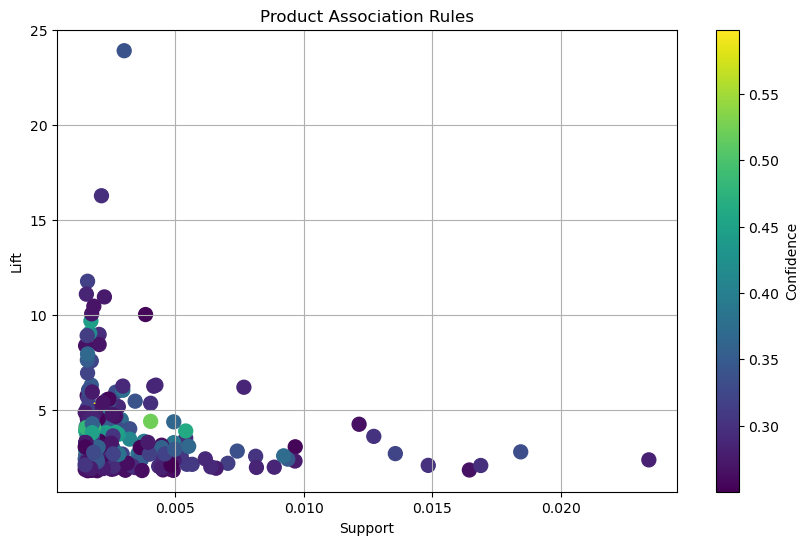

In [125]:

# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filter_product_rules['support'], filter_product_rules['lift'], c=filter_product_rules['confidence'], cmap='viridis', s=100)
plt.colorbar(scatter, label='Confidence')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Product Association Rules')
plt.grid(True)
plt.show()

In [142]:
# List of specific indices you are interested in
specific_indices = [13, 242, 16, 23]

# Selecting the specific rules based on indices
selected_rules = product_rules.loc[specific_indices, ['antecedents', 'consequents', 'support', 'confidence', 'lift']]
selected_rules

,antecedents,consequents,support,confidence,lift
13,(Bunched Cilantro),(Limes),0.004253,0.290625,6.320672
242,(Jalapeno Peppers),(Limes),0.004169,0.288046,6.264590
16,"(Bag of Organic Bananas, Organic Raspberries)",(Organic Hass Avocado),0.004047,0.298315,5.367004
23,"(Bag of Organic Bananas, Organic Raspberries)",(Organic Strawberries),0.004946,0.364607,4.391379


### 4.2 Aisle Association Rules

In [133]:
aisle_rules.describe()

,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
count,224898.000000,224898.000000,224898.000000,224898.000000,224898.000000,224898.000000,224898.000000,224898.000000
mean,0.004373,0.375180,0.002944,0.695094,1.980837,0.001326,2.447791,0.471532
std,0.005719,0.121107,0.003704,0.124416,0.474977,0.001325,1.343663,0.112679
min,0.001540,0.067229,0.001501,0.500000,0.909906,-0.003854,0.900772,-0.096954
25%,0.002523,0.253405,0.001730,0.584570,1.625726,0.000806,1.725074,0.386459
50%,0.003193,0.383030,0.002119,0.689373,1.886833,0.001035,2.024473,0.471941
75%,0.004504,0.450975,0.002980,0.795276,2.240549,0.001420,2.641535,0.556388
max,0.550099,0.550099,0.327333,0.990338,7.490056,0.079624,56.824071,0.869292


In [148]:
rows= ((aisle_rules['lift'] > 2.24) & (aisle_rules['support'] > 0.04) & (aisle_rules['support'] < 0.05) & (aisle_rules['confidence'] > 0.60))
aisle_rules[rows].sort_values('lift', ascending = False).reset_index().sort_values('support', ascending = False).reset_index()

,level_0,index,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,0,23394,"(fresh herbs, fresh fruits)","(packaged vegetables fruits, fresh vegetables)",0.074446,0.252361,0.044966,0.604013,2.393451,0.026179,1.88804,0.629021
1,1,23392,"(packaged vegetables fruits, fresh herbs)","(fresh vegetables, fresh fruits)",0.057641,0.327333,0.044966,0.780114,2.383244,0.026099,3.05916,0.615905


In [90]:
filter_aisle_rules = aisle_rules[aisle_rules['lift'] < 15]

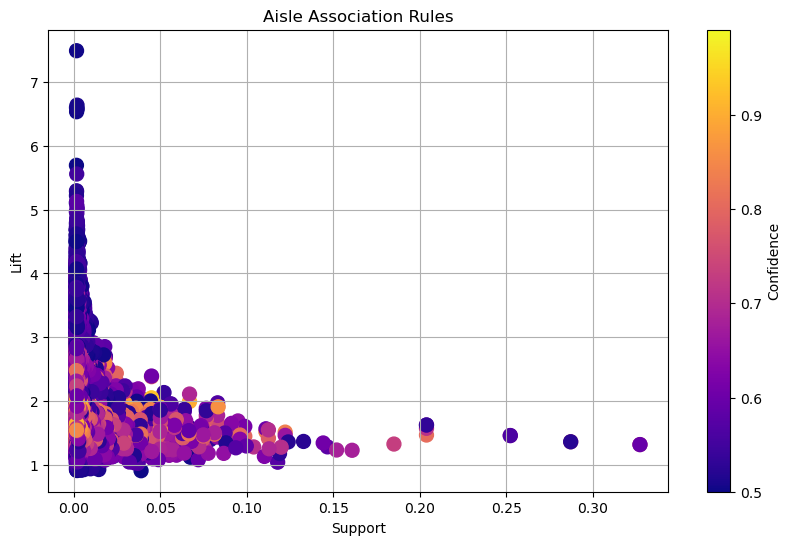

In [130]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(filter_aisle_rules['support'], filter_aisle_rules['lift'], c=filter_aisle_rules['confidence'], cmap='plasma', s=100)
plt.colorbar(scatter, label='Confidence')
plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Aisle Association Rules')
plt.grid(True)
plt.show()